In [ ]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

# Імпортуємо дані
Продовжимо працювати з [PIMA dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database) (Pima Indians Diabetes Database): 

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

In [ ]:
df = pd.read_csv('diabetes.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Вибір ознак

In [ ]:
df.corr().Outcome.to_frame().style.background_gradient()

,Outcome
Pregnancies,0.221898
Glucose,0.466581
BloodPressure,0.065068
SkinThickness,0.074752
Insulin,0.130548
BMI,0.292695
DiabetesPedigreeFunction,0.173844
Age,0.238356
Outcome,1.000000


Візьмемо лише дві ознаки, щоб мати можливість мати наглядну візуалізацію decision boundary класифікатора.

In [ ]:
X = df[['Glucose', 'Age']]
y = df['Outcome']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

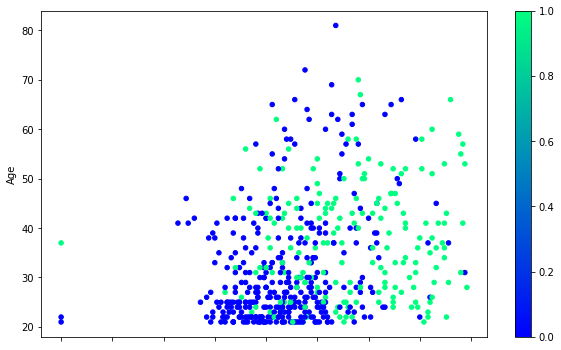

In [ ]:
X_train.plot.scatter(x='Glucose', y='Age', c=y_train, cmap='winter', figsize=(10,6));

## kNN Classifier

За замовчуванням в kNN використовується [відстань Мінковського](https://en.wikipedia.org/wiki/Minkowski_distance) p=2 (вона ж евклідова відстань):


За допомогою пошуку по сітці оберемо оптимальну кількість сусідів

In [ ]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [ ]:
knn_best = knn_gs.best_estimator_

print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 8} 0.7802007615091726


In [ ]:
knn_best = knn_gs.best_estimator_

Можемо зобразити decision boundary двома способами.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


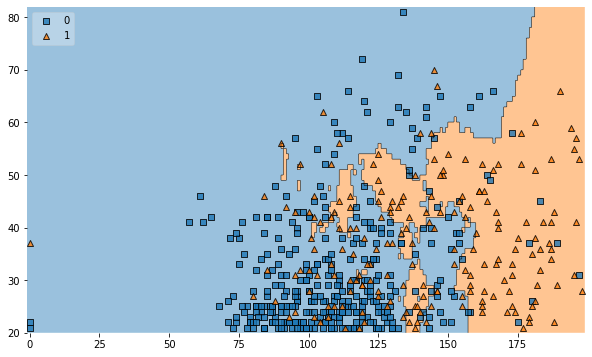

In [ ]:
from mlxtend.plotting import plot_decision_regions

plt.figure(figsize=(10,6))
plot_decision_regions(X_train.values, y_train.values, clf=knn_best, legend=2);

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    plt.figure(figsize=(10,6))
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

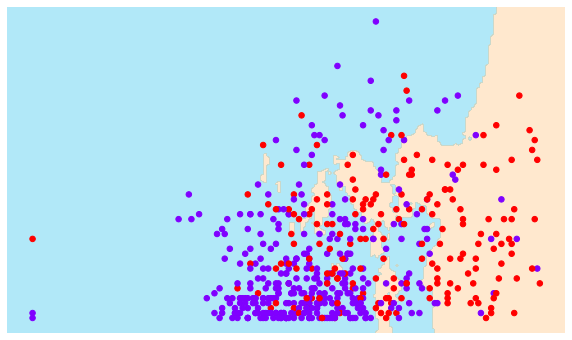

In [ ]:
visualize_classifier(knn_best, X_train.values, y_train.values);

In [ ]:
y_test_pred_proba = knn_best.predict_proba(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [ ]:
y_test_pred_proba[:4]

array([[0.625, 0.375],
       [0.75 , 0.25 ],
       [0.25 , 0.75 ],
       [0.5  , 0.5  ]])

In [ ]:
threshold = 0.4
y_pred = np.where(y_test_pred_proba[:,1]>threshold, 1,0)

In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7651    0.7600    0.7625       150
           1     0.5610    0.5679    0.5644        81

    accuracy                         0.6926       231
   macro avg     0.6630    0.6640    0.6635       231
weighted avg     0.6935    0.6926    0.6931       231



In [ ]:
def get_report(model, X_test, y_true):
    y_pred = model.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

In [ ]:
get_report(knn_best, X_train, y_train)

              precision    recall  f1-score   support

           0     0.8040    0.9257    0.8606       350
           1     0.8060    0.5775    0.6729       187

    accuracy                         0.8045       537
   macro avg     0.8050    0.7516    0.7667       537
weighted avg     0.8047    0.8045    0.7952       537



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [ ]:
get_report(knn_best, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7384    0.8467    0.7888       150
           1     0.6102    0.4444    0.5143        81

    accuracy                         0.7056       231
   macro avg     0.6743    0.6456    0.6516       231
weighted avg     0.6934    0.7056    0.6926       231



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


# Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
get_report(dt, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7241    0.7000    0.7119       150
           1     0.4767    0.5062    0.4910        81

    accuracy                         0.6320       231
   macro avg     0.6004    0.6031    0.6014       231
weighted avg     0.6374    0.6320    0.6344       231



# Logistic regression

In [ ]:
log_reg = LogisticRegression(solver='lbfgs', max_iter = 1000)

log_reg.fit(X_train, y_train)
get_report(log_reg, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7644    0.8867    0.8210       150
           1     0.7018    0.4938    0.5797        81

    accuracy                         0.7489       231
   macro avg     0.7331    0.6902    0.7003       231
weighted avg     0.7424    0.7489    0.7364       231



# Ensembling: Voting

In [ ]:
from sklearn.ensemble import VotingClassifier

Для `VotingClassifier` нам не потрібно попередньо тренувати моделі. Всередині `VotingClassifier` створює копії моделей і тренує їх самостійно. А потім агрегує





In [ ]:
dt = DecisionTreeClassifier()
knn_best = KNeighborsClassifier(n_neighbors=8)
log_reg = LogisticRegression(solver='lbfgs')

Модель не натренована, тому виникне помилка

In [ ]:
dt.predict(X_test)

NotFittedError: ignored

In [ ]:
# створюємо словник моделей
estimators=[('knn', knn_best), ('dt', dt), ('log_reg', log_reg)]

# voting класифікатор
ensemble = VotingClassifier(estimators)

ensemble.fit(X_train, y_train)
get_report(ensemble, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7299    0.8467    0.7840       150
           1     0.5965    0.4198    0.4928        81

    accuracy                         0.6970       231
   macro avg     0.6632    0.6332    0.6384       231
weighted avg     0.6831    0.6970    0.6818       231



Натренувались лиш копії, самі моделі, що ми оголосили раніше, так і лишились ненатреновані

In [ ]:
dt.predict(X_test)

NotFittedError: ignored

Отримати всі естіматори ансабля можна так

In [ ]:
ensemble.estimators_

[KNeighborsClassifier(n_neighbors=8),
 DecisionTreeClassifier(),
 LogisticRegression()]

А отримати передбачення конкретного естіматора так

In [ ]:
ensemble.estimators_[1].predict(X_test)

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1])

Soft voting - це коли усереднюються вірогідності приналежності до класів, а отже можливий лиш для класифікаторів, які можуть передбачати вірогідност (predict proba).   
Давайте спроьуємо застосувати soft voting.

In [ ]:
ensemble = VotingClassifier(estimators, voting='soft')

ensemble.fit(X_train, y_train)
get_report(ensemble, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7500    0.7600    0.7550       150
           1     0.5443    0.5309    0.5375        81

    accuracy                         0.6797       231
   macro avg     0.6472    0.6454    0.6462       231
weighted avg     0.6779    0.6797    0.6787       231



Можем зробити зважене усереднення

In [ ]:
ensemble = VotingClassifier(estimators, voting ='hard', weights=[2, 1, 10])

ensemble.fit(X_train, y_train)
get_report(ensemble, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7644    0.8867    0.8210       150
           1     0.7018    0.4938    0.5797        81

    accuracy                         0.7489       231
   macro avg     0.7331    0.6902    0.7003       231
weighted avg     0.7424    0.7489    0.7364       231



# Stacking

stack_method : {'auto', 'predict_proba', 'decision_function', 'predict'},             default='auto'
    Methods called for each base estimator. It can be:

    * if 'auto', it will try to invoke, for each estimator,
      `'predict_proba'`, `'decision_function'` or `'predict'` in that
      order.
    * otherwise, one of `'predict_proba'`, `'decision_function'` or
      `'predict'`. If the method is not implemented by the estimator, it
      will raise an error.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier


estimators=[('knn', knn_best), ('dt', dt), ('log_reg', log_reg)]
stacking_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train, y_train)
get_report(stacking_clf, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7515    0.8267    0.7873       150
           1     0.6061    0.4938    0.5442        81

    accuracy                         0.7100       231
   macro avg     0.6788    0.6602    0.6658       231
weighted avg     0.7005    0.7100    0.7021       231



Модель стеккінгу має наступні атрибути:

In [ ]:
vars(stacking_clf)

{'estimators': [('knn', KNeighborsClassifier(n_neighbors=8)),
  ('dt', DecisionTreeClassifier()),
  ('log_reg', LogisticRegression())],
 'final_estimator': LogisticRegression(),
 'cv': None,
 'stack_method': 'auto',
 'n_jobs': None,
 'verbose': 0,
 'passthrough': False,
 '_le': LabelEncoder(),
 'classes_': array([0, 1]),
 'final_estimator_': LogisticRegression(),
 'estimators_': [KNeighborsClassifier(n_neighbors=8),
  DecisionTreeClassifier(),
  LogisticRegression()],
 'named_estimators_': {'knn': KNeighborsClassifier(n_neighbors=8),
  'dt': DecisionTreeClassifier(),
  'log_reg': LogisticRegression()},
 'feature_names_in_': array(['Glucose', 'Age'], dtype=object),
 'stack_method_': ['predict_proba', 'predict_proba', 'predict_proba']}

Модна подивитись, які значення повертає фінальна модель при різних вхідних значеннях

In [ ]:
stacking_clf.final_estimator_.predict([[1,0,0]])

array([1])

In [ ]:
stacking_clf.final_estimator_.predict([[0,1,1]])

array([0])

Виглядає, що самою впливовою виявилась модель knn )))

# Bagging 

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=4), n_estimators=1000,
    max_samples=500,  n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)

get_report(bag_clf, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7403    0.7600    0.7500       150
           1     0.5325    0.5062    0.5190        81

    accuracy                         0.6710       231
   macro avg     0.6364    0.6331    0.6345       231
weighted avg     0.6674    0.6710    0.6690       231



## Out-of-Bag Evaluation

**oob_score** - 
Whether to use out-of-bag samples to estimate the generalization error. 

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42,
    oob_score=True
)
bag_clf.fit(X_train, y_train)

get_report(bag_clf, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7484    0.7933    0.7702       150
           1     0.5694    0.5062    0.5359        81

    accuracy                         0.6926       231
   macro avg     0.6589    0.6498    0.6531       231
weighted avg     0.6857    0.6926    0.6881       231



In [ ]:
bag_clf.oob_score_

0.750465549348231

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=5, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

get_report(rnd_clf, X_test, y_test)

              precision    recall  f1-score   support

           0     0.7374    0.8800    0.8024       150
           1     0.6538    0.4198    0.5113        81

    accuracy                         0.7186       231
   macro avg     0.6956    0.6499    0.6569       231
weighted avg     0.7081    0.7186    0.7003       231



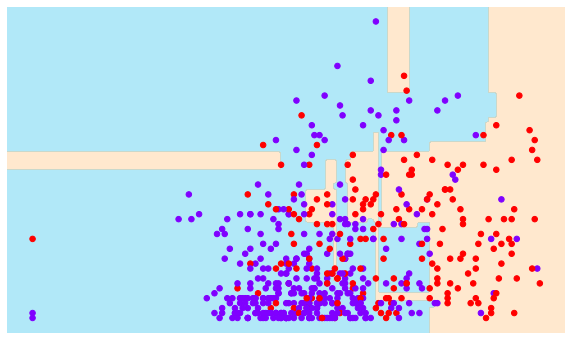

In [ ]:
visualize_classifier(rnd_clf, X_train.values, y_train.values);

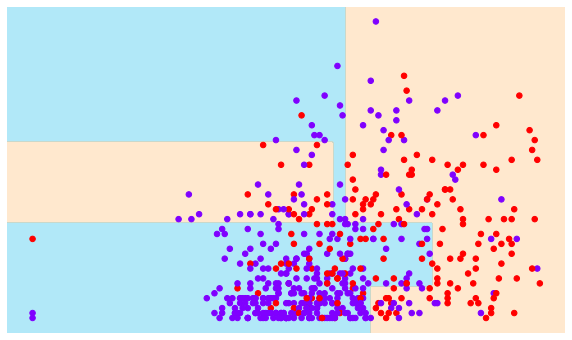

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=1, max_leaf_nodes=8, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
visualize_classifier(rnd_clf, X_train.values, y_train.values);

Підберемо гіперпараметри:

In [ ]:
rf = RandomForestClassifier(random_state=42)
params_rf = {
    'n_estimators': [1, 5, 10, 50, 100, 200],
    'max_leaf_nodes':[4,8,16,32]
}
rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs.fit(X_train, y_train)
rf_best = rf_gs.best_estimator_
print(rf_gs.best_params_)

get_report(rf_best, X_test, y_test)

{'max_leaf_nodes': 8, 'n_estimators': 1}
              precision    recall  f1-score   support

           0     0.7466    0.7267    0.7365       150
           1     0.5176    0.5432    0.5301        81

    accuracy                         0.6623       231
   macro avg     0.6321    0.6349    0.6333       231
weighted avg     0.6663    0.6623    0.6641       231



Scoring краще обирати свій, інакше буде використовуватись той, що по дефолту в алгоритма, а у RandomForestClassifier - accuracy.

In [ ]:
rf = RandomForestClassifier(random_state=42)
params_rf = {'n_estimators': [1, 5, 10, 50, 100, 200],
            'max_leaf_nodes':[4, 8, 16, 32]}
rf_gs = GridSearchCV(rf, params_rf, cv=5, scoring='f1_micro')
rf_gs.fit(X_train, y_train)
rf_best = rf_gs.best_estimator_
print(rf_gs.best_params_)

get_report(rf_best, X_test, y_test)

{'max_leaf_nodes': 8, 'n_estimators': 1}
              precision    recall  f1-score   support

           0     0.7466    0.7267    0.7365       150
           1     0.5176    0.5432    0.5301        81

    accuracy                         0.6623       231
   macro avg     0.6321    0.6349    0.6333       231
weighted avg     0.6663    0.6623    0.6641       231



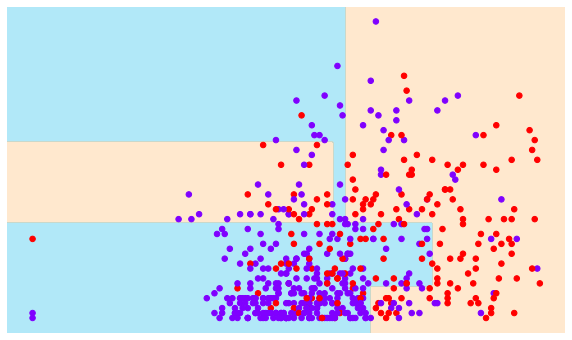

In [ ]:
visualize_classifier(rf_best, X_train.values, y_train.values);

# Random forest regression

In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

In [ ]:
def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

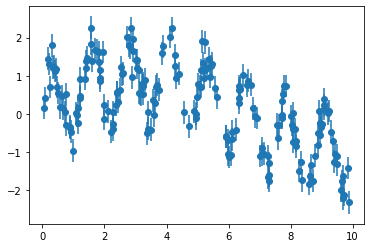

In [ ]:
y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

In [ ]:
x.shape

(200,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=200)
forest.fit(x[:, None], y)

RandomForestRegressor(n_estimators=200)

In [ ]:
xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

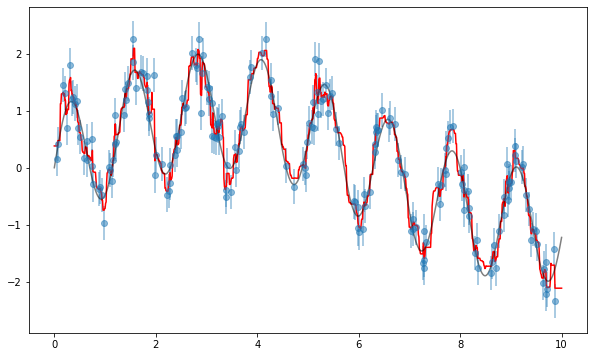

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

# Random forest для класифікації рукописних цифер

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
digits.data.max()

16.0

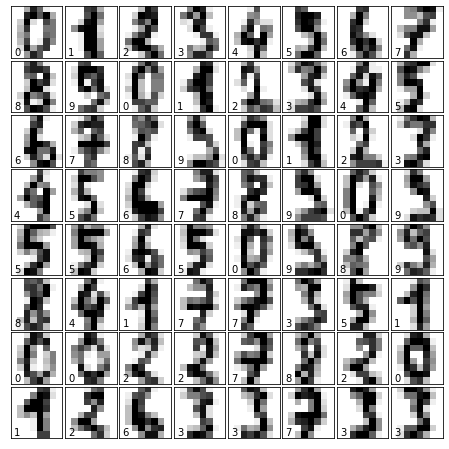

In [ ]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [ ]:
digits.data.shape

(1797, 64)

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.96      0.98        45
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



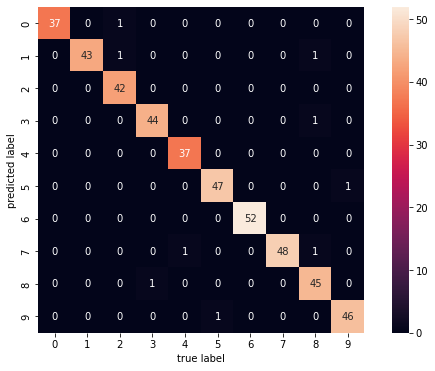

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, ypred)
plt.figure(figsize=(10,6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');